In [1]:
import numpy as np
import matplotlib.pyplot as plt

Occupant class and function definitions

In [2]:
def sigmoid(x, a=0, k=1):
    return (1 / (1 + np.exp(-k*(x - a))))

def get_steepness(y, x):
    k = - np.log((1 / y) - 1) / x
    return k

def scale_outdoor_temp(t, min_temp, max_temp, to_interval=(-1, 1)):
    int_min, int_max = to_interval
    t_scaled = (t - min_temp) / (max_temp - min_temp) * (int_max - int_min) + int_min
    return t_scaled


class Agent:
    def __init__(self, setpoint_low=(20.0, 20.0), setpoint_high=(23.0, 18.00)):
        """Occupant class for setpoint feedback.

        Args:
            setpoint_low (outdoor_temperature, setpoint): Lower limit of cooling setpoint. Indicates 
                the outdoor_temperature at which the highest cooling setpoint (= weakest cooling) should be returned.
            setpoint_high (outdoor_temperature, setpoint): Upper limit of cooling setpoint. Indicates 
                the outdoor_temperature at which the lowest cooling setpoint (= strongest cooling) should be returned.

        """
        
        self.temp_out_low, self.cooling_low = setpoint_low
        self.temp_out_high, self.cooling_high = setpoint_high
        self.scale_interval=(self.temp_out_low, self.temp_out_high)
        self.k = get_steepness(0.95, 1)

    def setpoint_feedback(self, outside_temp):
        # x = scale_outdoor_temp(outside_temp, self.tmin, self.tmax)
        x = scale_outdoor_temp(outside_temp, self.temp_out_low, self.temp_out_high)
        return self._get_setpoint(x)

    def _get_setpoint(self, x):
        y = sigmoid(x, k=self.k) * (-1)
        y = self._scale_setpoint(y)
        return y
    
    def _scale_setpoint(self, y):
        x_min, x_max = (-1, 0)
        min, max = (self.cooling_high, self.cooling_low)
        y_scaled = (y - x_min) / (x_max - x_min) * (max - min) + min
        return y_scaled
    

class Office:
    def __init__(self, occupants):
        """Helper class to get combined feedback from multiple occupants.

        Args:
            occupants: List of occupants from class Agent.
        """

        self.occupants = occupants
    
    def get_combined_feedback(self, outside_temp, occupants_idx):
        """Returns combined setpoint feedback (simple mean).

        Args:
            outside_temp: Current outside temperature
            occupants_idx (_type_): Indices of occupants from occupants list currently in the office.

        Returns:
            Mean setpoint feedback.
        """
        setpoint_feedback = 0
        for i in occupants_idx:
            setpoint_feedback += self.occupants[i].setpoint_feedback(outside_temp)
        return setpoint_feedback / len(occupants_idx)

Occupancy function example

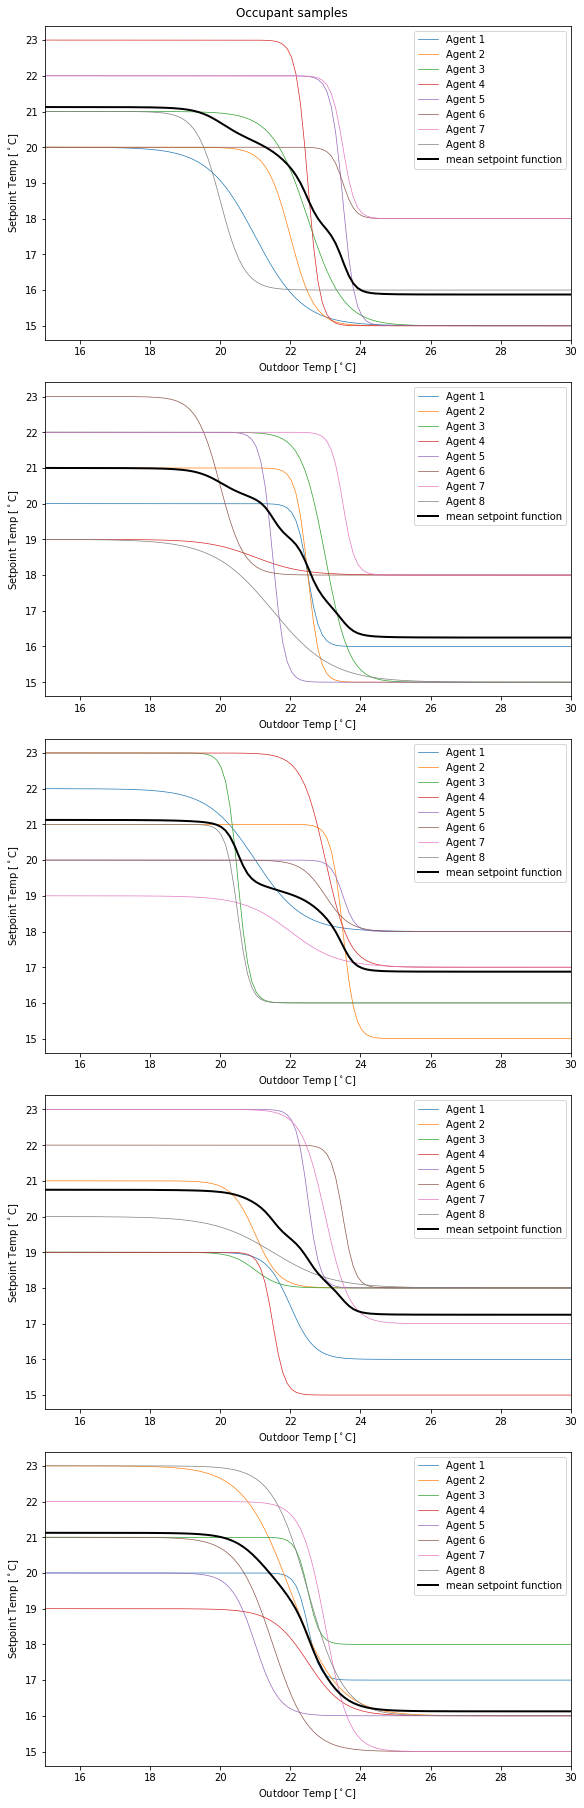

In [3]:
# outdoor temp limits
tmin = 15
tmax = 40

n_eval = 200
n_occupants = 8

occupants_setpoints = np.zeros((n_occupants, n_eval))

# outdoor temperature array
outdoor_temp = np.linspace(tmin, tmax, n_eval)

n_samples = 5
fig, ax = plt.subplots(5, 1, figsize=(8, 5*n_samples), layout="constrained")
for i in range(n_samples):
    for j in range(n_occupants):

        # occupant setpoint samples
        temp_low = np.random.choice(np.arange(19, 24))
        cooling_low = np.random.choice(np.arange(19, 24))
        temp_high = np.random.choice(np.arange(temp_low + 1, 25))
        cooling_high = np.random.choice(np.arange(15, 19))

        # generate occupant agent
        o = Agent(setpoint_low=(temp_low, cooling_low), setpoint_high=(temp_high, cooling_high))
        # get setpoint
        setpoints = o.setpoint_feedback(outdoor_temp)
        
        occupants_setpoints[j] = setpoints
        ax[i].plot(outdoor_temp, setpoints, label=f"Agent {j+1}", linewidth=.7)
    ax[i].plot(outdoor_temp, occupants_setpoints.mean(axis=0), "black", linewidth=2, label="mean setpoint function")
    ax[i].set_ylabel(r"Setpoint Temp [$^\circ$C]")
    ax[i].set_xlabel(r"Outdoor Temp [$^\circ$C]")
    ax[i].set_xlim(15, 30)
    ax[i].legend()
fig.suptitle('Occupant samples')
# fig.tight_layout()
plt.show()

Office class example

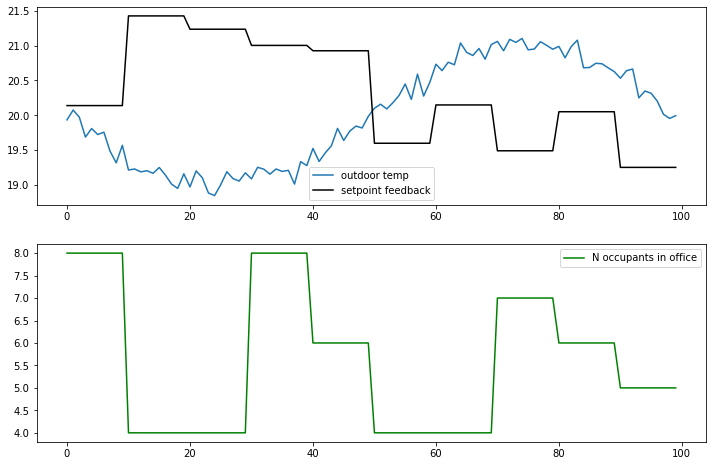

In [4]:
# outdoor temp limits
tmin = 15
tmax = 40

n_eval = 200
n_occupants = 8

# outdoor temperature array
outdoor_temp = np.linspace(tmin, tmax, n_eval)

occupants_list = []

for j in range(n_occupants):

    # occupant setpoint samples
    temp_low = np.random.choice(np.arange(19, 24))
    cooling_low = np.random.choice(np.arange(19, 24))
    temp_high = np.random.choice(np.arange(temp_low + 1, 25))
    cooling_high = np.random.choice(np.arange(15, 19))

    # generate occupant agent
    o = Agent(setpoint_low=(temp_low, cooling_low), setpoint_high=(temp_high, cooling_high))
    occupants_list.append(o)

office = Office(occupants_list)

# generate outdoor temperature trajectory
outdoor_temp = np.sin(np.linspace(-np.pi, np.pi, 100)) + 20 + np.random.randn(100) * 0.1
eval_interval = 10 #evaluation interval

feedback_t = []
num_occupants_t = []
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
for t in outdoor_temp[::eval_interval]:

    #select random occupants in office
    n_occupants_in_office = np.random.randint(4, len(occupants_list)+1)
    occupants_in_office = np.random.choice(np.arange(len(occupants_list)), size=n_occupants_in_office, replace=False)
    y = office.get_combined_feedback(t, occupants_in_office)
    feedback_t.extend([y]*eval_interval)
    num_occupants_t.extend([n_occupants_in_office]*eval_interval)

ax[0].plot(outdoor_temp, label="outdoor temp")
ax[0].plot(feedback_t, color='black', label="setpoint feedback")
ax[0].legend()
ax[1].plot(num_occupants_t, color="green", label="N occupants in office")
ax[1].legend()